In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import xgboost as xgb

In [2]:
# read the data
df = pd.read_csv("fraud.csv")

In [3]:
# check the structure the data
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isUnrecognizedDevice,isOutsideLocation
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0


In [4]:
pd.crosstab(index = df["isUnrecognizedDevice"], columns = "count")

col_0,count
isUnrecognizedDevice,
0,6354465
1,8155


In [5]:
# check the structure of the data
df.shape

(6362620, 13)

In [6]:
# check the structure of the data
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isUnrecognizedDevice,isOutsideLocation
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06,1.281705e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03,3.577796e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
# check the distribution of target column
pd.crosstab(index = df['isFraud'], columns = 'count')

col_0,count
isFraud,
0,6354407
1,8213


In [8]:
dist = df.groupby(['isFraud'])['isFraud'].agg(['count']).rename(columns = {'count':'Distribution'})
dist['Percentage'] = dist['Distribution']/df.shape[0]
dist

,Distribution,Percentage
isFraud,,
0,6354407,0.998709
1,8213,0.001291


In [9]:
# sample the data
data_sample = df.sample(frac=0.30, random_state=100)

In [10]:
# check the structure of the sampled data
data_sample.shape

(1908786, 13)

In [11]:
# initiate for train test split
from sklearn.model_selection import train_test_split

In [12]:
droplist = ["type","isFraud", "nameDest", "nameOrig", "amount", "isFlaggedFraud"]
X = data_sample.drop(columns = droplist)
y = data_sample["isFraud"] 

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100
)

In [14]:
# now look for better parameter combination
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# https://www.kaggle.com/phunter/xgboost-with-gridsearchcv
# https://xgboost.readthedocs.io/en/latest/parameter.html
parameters = {
    "nthread": [1],  # when use hyperthread, xgboost may become slower
    "objective": ["binary:logistic"],
    "learning_rate": [0.02],  # so called `eta` value
    "max_depth": [6],
    "min_child_weight": [1],
    "silent": [1],
    "subsample": [1],
    "colsample_bytree": [1],
    "n_estimators": [100],  # number of trees, change it to 1000 for better results
    "missing": [-999],
    "seed": [1337],
}

In [15]:
# now fit the model
xgboost = GridSearchCV(
    xgb.XGBClassifier(),
    parameters,
    n_jobs=5,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100),
    scoring="roc_auc",
    verbose=2,
    refit=True,
)
xgboost.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.8min finished


[17:30:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_w...
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [1], 'learning_rate': [0.02],
                         'max_depth': [6], 'min_child_weight': [1],
                         'missing': [-999], 'n_estimators': [100],
              

In [16]:
# get the best parameter
xgboost.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.02,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': -999,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'binary:logistic',
 'seed': 1337,
 'silent': 1,
 'subsample': 1}

In [17]:
xgboost.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.4min finished


[17:37:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_w...
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [1], 'learning_rate': [0.02],
                         'max_depth': [6], 'min_child_weight': [1],
                         'missing': [-999], 'n_estimators': [100],
              

In [18]:
# check the importance of the features
xgboost.best_estimator_.feature_importances_

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

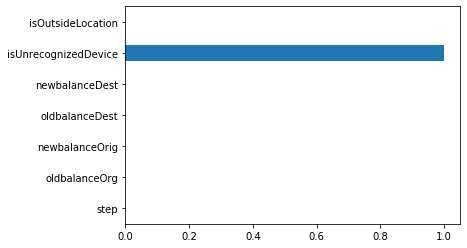

In [19]:
ft_importance = pd.Series(xgboost.best_estimator_.feature_importances_, index = X.columns)
ft_importance.plot(kind = 'barh')

In [20]:
# predict using the test set
y_pred = xgboost.predict(X_test)

In [21]:
# prepare the reports
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [22]:
# save the report
report = classification_report(y_test, y_pred, output_dict=True)
report_save = pd.DataFrame(report).transpose()
report_save.to_csv("report.csv")

In [23]:
# print the report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    381238
           1       1.00      0.99      1.00       520

    accuracy                           1.00    381758
   macro avg       1.00      1.00      1.00    381758
weighted avg       1.00      1.00      1.00    381758



In [24]:
print(confusion_matrix(y_test, y_pred))

[[381238      0]
 [     5    515]]


In [25]:
accuracy_score(y_test, y_pred)

0.9999869026975204

In [26]:
# test a new entry
test_case = [800, 50000000, 15428700, 1000000, 145000000, 1, 0]
test_case = pd.DataFrame(test_case).T
test_case.columns = X_train.columns
test_case

,step,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isUnrecognizedDevice,isOutsideLocation
0,800,50000000,15428700,1000000,145000000,1,0


In [27]:
test_case_verdict = xgboost.predict(test_case)
np.where(test_case_verdict == 0, "Regular Transaction", "Suspicious Transaction")[0]

'Suspicious Transaction'

In [28]:
xgboost.predict_proba(test_case)

array([[0.06777561, 0.9322244 ]], dtype=float32)

In [29]:
# save the model for further use
import pickle
file = open("fraud_detection.pkl", "wb")
pickle.dump(xgboost, file)